In [49]:
import tensorflow as tf

time: 17.3 ms


So 3 rows per image (for R G B); flatten (32x32 = 1024)

In [50]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    fdict = cPickle.load(fo)
    fo.close()
    return fdict

time: 17.5 ms


In [51]:
data = unpickle('cucumber_data/p1/data_batch_1')
data.keys()

['batch_label', 'labels', 'data', 'filenames']

time: 22 ms


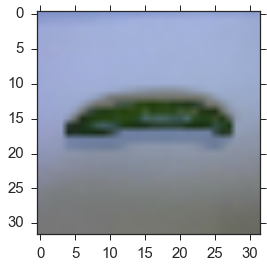

time: 240 ms


In [52]:
imgplot = plt.imshow(
    np.array(zip(
            data['data'][312],
            data['data'][313],
            data['data'][314]))
    .reshape((32, 32, 3))
)

In [53]:
def flatten_image(image):
    return [item for sublist in image for item in sublist]

def format_data(data):
    images = []
    data_size = len(data)/3
    for i in xrange(data_size):
        images.append(flatten_image(data[3*i:3*i+3]))
    return images

def format_label(labels):
    prep = [np.array([0]*9) for i in xrange(len(labels))]
    for i in xrange(len(labels)):
        prep[i][labels[i]] += 1
    return prep

time: 28.3 ms


In [54]:
def get_batch(file):
    data_batch = unpickle(file)
    data = format_data(data_batch['data'])
    labels = format_label(data_batch['labels'])
    return data, labels

time: 20.8 ms


In [55]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

time: 27.4 ms


### Layer 1 (Convolutional)

In [56]:
x = tf.placeholder(tf.float32, [None, 3*32*32])
x_image = tf.reshape(x, [-1,32,32,3])
y_ = tf.placeholder(tf.float32, [None, 9])

time: 28.6 ms


In [57]:
neurons1 = 32

time: 22.2 ms


In [58]:
W_conv1 = weight_variable([2, 2, 3, neurons1])
b_conv1 = bias_variable([neurons1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

time: 41.2 ms


### Layer 2 (Convolutional)

In [59]:
neurons2 = 64

time: 20.8 ms


In [60]:
W_conv2 = weight_variable([2, 2, neurons1, neurons2])
b_conv2 = bias_variable([neurons2])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

time: 42.2 ms


### Layer 3 (Convolutional)

In [61]:
neurons3 = 128

time: 24.5 ms


In [62]:
W_conv3 = weight_variable([2, 2, neurons2, neurons3])
b_conv3 = bias_variable([neurons3])

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

time: 40.5 ms


### Layer 4 (Densely connected)

In [63]:
neurons4 = 2**9

time: 16.7 ms


In [64]:
W_fc1 = weight_variable([4 * 4 * neurons3, neurons4])
b_fc1 = bias_variable([neurons4])

h_pool3_flat = tf.reshape(h_pool3, [-1, 4*4*neurons3])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

time: 34.9 ms


### Layer 5 (softmax, with dropout)

In [65]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

time: 27.3 ms


In [66]:
W_fc2 = weight_variable([neurons4, 9])
b_fc2 = bias_variable([9])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

time: 33.5 ms


### Training

In [67]:
sess = tf.InteractiveSession()
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())

time: 813 ms


In [68]:
from random import shuffle

time: 19.2 ms


In [69]:
def train_cycle():
    train_order = range(1, 6)
    shuffle(train_order)
    for i in train_order:
        batch_xs, batch_ys = get_batch('cucumber_data/p1/data_batch_{}'.format(i))
        train_step.run(feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})

time: 20.2 ms


In [70]:
def test_cycle():
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    test_x, test_y = get_batch('cucumber_data/p1/test_batch')
    print(sess.run(accuracy, feed_dict={x: test_x,
                                      y_: test_y,
                                      keep_prob: 1.0}))

time: 18.8 ms


In [ ]:
for i in xrange(6000):
    train_cycle()
    if i % 100 == 0:
        print "Round {}".format(i)
        test_cycle()

Round 0
0.137374
